In [45]:
%load_ext autoreload
%autoreload 2

import os
import csv
import numpy as np
import shapely
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch


from torch.utils.data import DataLoader, RandomSampler, ConcatDataset
from pytorch_lightning.utilities import CombinedLoader
from pathlib import Path
from datetime import datetime
#import torchvision.models as models

import dl_toolbox.callbacks as callbacks
import dl_toolbox.modules as modules 
import dl_toolbox.networks as networks
import dl_toolbox.datasets as datasets
import dl_toolbox.torch_collate as collate
import dl_toolbox.utils as utils

import rasterio.windows as windows

torch.set_float32_matmul_precision('high')
test = False
if os.uname().nodename == 'WDTIS890Z': 
    data_root = Path('/mnt/d/pfournie/Documents/data')
    home = Path('/home/pfournie')
    save_root = data_root / 'outputs'
elif os.uname().nodename == 'qdtis056z': 
    data_root = Path('/data')
    home = Path('/d/pfournie')
    save_root = data_root / 'outputs'
elif os.uname().nodename.endswith('sis.cnes.fr'):
    home = Path('/home/eh/fournip')
    save_root = Path('/work/OT/ai4usr/fournip') / 'outputs'
    if test:
        data_root = Path('/work/OT/ai4geo/DATA/DATASETS')
    else:
        data_root = Path(os.environ['TMPDIR'])

# datasets params
dataset_name = 'DIGITANIE'
data_path = data_root / dataset_name
nomenclature = datasets.DigitanieNomenclatures['building'].value
num_classes=len(nomenclature)
crop_size=256
crop_step=224
bands = [1,2,3]
focus_rad = 20

# split params
split = home / f'dl_toolbox/dl_toolbox/datamodules/digitanie_all.csv'

TO_idx = [0, 66, 88, 99, 110, 154, 165]
train_idx = [i+j for i in TO_idx for j in range(1,8)]
train_aug = 'd4_color-3'

val_idx = [i+j for i in TO_idx for j in range(8,9)]
val_aug = 'd4_color-3'

# dataloaders params
batch_size = 16
epoch_steps = 1000
num_samples = epoch_steps * batch_size
num_workers=6

# network params
in_channels=len(bands)+1
out_channels=num_classes
pretrained = None

# module params
mixup=0. # incompatible with ignore_zero=True
class_weights = [1., 3.] #[1.] * num_classes
initial_lr=0.001
ttas=[]

# trainer params
num_epochs = 100
#max_steps=num_epochs * epoch_steps
accelerator='gpu'
devices=1
multiple_trainloader_mode='min_size'
limit_train_batches=1.
limit_val_batches=1.
save_dir = save_root / dataset_name
log_name = 'classif_digi_ce'
ckpt_path=None 


train_data_src = [
    src for src in datasets.datasets_from_csv(
        data_path,
        split,
        train_idx
    )
]

train_sets = [
    datasets.Raster2Cls(
        data_src=src,
        crop_size=crop_size,
        aug=train_aug,
        bands=bands,
        nomenclature=nomenclature,
        focus_rad=focus_rad
    ) for src in train_data_src
]

train_set = ConcatDataset(train_sets)

val_data_src = [
    src for src in datasets.datasets_from_csv(
        data_path,
        split,
        val_idx
    )
]

val_sets = [
    datasets.Raster2Cls(
        data_src=src,
        crop_size=crop_size,
        #crop_step=crop_size//2,
        aug=val_aug,
        bands=bands,
        nomenclature=nomenclature,
        focus_rad=focus_rad
    ) for src in val_data_src
]

val_set = ConcatDataset(val_sets)

train_dataloaders = {}
train_dataloaders['sup'] = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    collate_fn=collate.CustomCollate(),
    sampler=RandomSampler(
        data_source=train_set,
        replacement=True,
        num_samples=num_samples
    ),
    num_workers=num_workers,
    drop_last=True
)

val_dataloader = DataLoader(
    dataset=val_set,
    #shuffle=False,
    sampler=RandomSampler(
        data_source=val_set,
        replacement=True,
        num_samples=num_samples//10
    ),
    collate_fn=collate.CustomCollate(),
    batch_size=batch_size,
    num_workers=num_workers
)

#from torchvision.ops.misc import Conv2dNormActivation

network = networks.efficientnet_b0(
    num_classes=out_channels if pretrained is None else 1000,
    weights=pretrained
)
#network.features[0] = Conv2dNormActivation(
#    in_channels,
#    32,
#    kernel_size=3,
#    stride=2,
#    norm_layer=nn.BatchNorm2d,
#    activation_layer=nn.SiLU
#)

### Building lightning module
module = modules.Supervised(
    mixup=mixup, # incompatible with ignore_zero=True
    network=network,
    num_classes=num_classes,
    class_weights=class_weights,
    initial_lr=initial_lr,
    ttas=ttas
)


### Metrics and plots from confmat callback
metrics_from_confmat = callbacks.MetricsFromConfmat(        
    num_classes=num_classes,
    class_names=[label.name for label in nomenclature]
)

logger = pl.loggers.TensorBoardLogger(
    save_dir=save_dir,
    name=log_name,
    version=f'{datetime.now():%d%b%y-%Hh%Mm%S}'
)

### Trainer instance
trainer = pl.Trainer(
    max_epochs=num_epochs,
    accelerator=accelerator,
    devices=devices,
    num_sanity_val_steps=0,
    limit_train_batches=limit_train_batches,
    limit_val_batches=limit_val_batches,
    logger=logger,
    callbacks=[
        pl.callbacks.ModelCheckpoint(),
        pl.callbacks.EarlyStopping(
            monitor='Val_loss',
            patience=10
        ),
        metrics_from_confmat,
        callbacks.MyProgressBar()
    ]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


tensor([0.4265, 0.5735]) tensor(1)
[0 1]
(4, 256, 256)


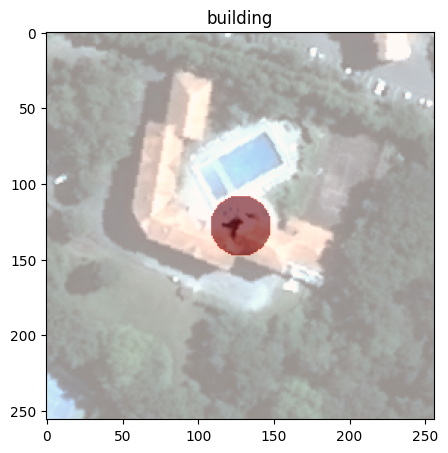

In [79]:
%matplotlib inline
from shapely import plotting
from matplotlib import colors
import matplotlib.pyplot as plt
from copy import copy
from rasterio import plot as rioplt

labels = []
for _ in range(1):
    i = np.random.randint(len(train_set))
    item = train_set[i]
    labels.append(item['label'].numpy()) 
print(np.bincount(labels))
    
#item =ds[1]
image=item['image'].numpy()
print(image.shape)
#print(image.min())
#rioplt.show(image, ax=ax, transform=item['crop_tf'])
#ax.axis('equal')
#ax.autoscale_view()

fig, (ax1) = plt.subplots(1, 1, figsize=(5,10))
#rioplt.show(image[:3,...], ax=ax1, transform=item['crop_tf'])
ax1.imshow(image[:3].transpose(1,2,0))
ax1.set_title(nomenclature[item['label'].numpy()].name)
ax1.imshow(image[3], cmap='Reds',alpha=0.6)
#ax2.imshow(image[3], cmap='Reds',alpha=0.6)

In [5]:
trainer.fit(
    model=module,
    train_dataloaders=CombinedLoader(train_dataloaders, mode=multiple_trainloader_mode),
    val_dataloaders=val_dataloader,
    ckpt_path=ckpt_path
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | network | EfficientNet     | 4.0 M 
1 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.040    Total estimated model params size (MB)
/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Epoch 0:   0%|                                                                                                                                                                  | 0/1000 [00:00<?, ?it/s]

RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED